In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class MLP():
    activations = ['relu', 'sigmoid', 'tanh', 'softmax']
    weight_initializations = ['zero', 'random', 'normal']
    optimizers = ['momentum', 'nag', 'adagrad', 'rmsprop', 'adam','sgd']
    
    def __init__(self, layer_sizes, activation, lr, weight_initialization, batch_size, epochs, optimizer):
        
        #simple MLP parameters
        self.n_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.lr = lr
        self.weight_initialization = weight_initialization
        self.batch_size = batch_size
        self.epochs = epochs
        self.W,self.B=self.initialize_weights()  #Weight and Bias dictionary respectively
        self.A={}   #Activation values
        self.Z={}   #Pre activation values
        self.W_grad , self.B_grad = self.initialize_weights(zero=True)
        self.A_grad = {}
        self.Z_grad = {}
        self.train_loss = []
        self.train_epochs = []
        self.val_epochs = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        
        # optimizer parameters
        self.momentum_W, self.momentum_B = self.initialize_weights(zero=True)
        self.optimizer = optimizer
        self.G_ada_grad_W = 0
        self.G_ada_grad_B = 0
        self.E_rms_prop_W = 0
        self.E_rms_prop_B = 0
        self.beta = 0.9
        self.epsilon = 1e-8
        self.gamma = 0.99
        self.V_adam_W = 0
        self.V_adam_B = 0
        
    def activate(self, arr, name, grad=False):
        if(name == 'relu'):
            if(not grad):
                arr[arr<0] = 0
                
            else:
                arr[arr<0] = 0
                arr[arr>0] = 1
                
        elif(name == 'sigmoid'):
            if(not grad):
                arr = 1/(1 + np.exp(-arr))
                
            else:
                x = self.activate(arr,'sigmoid')
                arr = x * (1-x)
                
        elif(name == 'tanh'):
            if(not grad):
                arr = np.tanh(arr)
            
            else:
                y = np.tanh(arr)
                arr = 1-y*y
                
        else:
            #softmax derivative is a jacobian matrix
            y = np.exp(arr)
            arr = y/(np.sum(y,axis = 1, keepdims = True))
            
        
        mini = 1e-20
        maxi = 1e20
        arr[arr<mini] = 0
        arr[arr>maxi] = maxi
        return arr

    def initialization(self, name, shape):
        x = np.zeros(shape)
        if(name == 'random'):
            x = np.random.rand(shape[0],shape[1])*0.01
            
        elif(name == 'normal'):
            x = np.random.normal(size = shape)*0.01
        
        return x
    
    def initialize_weights(self, zero=False):
        Weight={}
        Bias={}
        
        if(zero):
            for i in range(self.n_layers-1):
                Weight[i+1] = self.initialization('zero', (self.layer_sizes[i],self.layer_sizes[i+1]))
                Bias[i+1] = self.initialization('zero', (1,self.layer_sizes[i+1])) 
        else:
            for i in range(self.n_layers-1):
                Weight[i+1] = self.initialization(self.weight_initialization, (self.layer_sizes[i],self.layer_sizes[i+1]))
                Bias[i+1] = self.initialization(self.weight_initialization, (1,self.layer_sizes[i+1]))    
        
        return Weight, Bias
    
    def optimize(self, optimizer, l, time):
        if(optimizer == 'momentum' or optimizer == 'nag'):
            #for nag adjustment is made in fit function
            self.momentum_W[l] = self.beta * self.momentum_W[l] - self.lr * self.W_grad[l]
            self.momentum_B[l] = self.beta * self.momentum_B[l] - self.lr * self.B_grad[l]
            
            return self.momentum_W[l], self.momentum_B[l]
            
        elif(optimizer == 'adagrad'):
            
            self.G_ada_grad_W += np.dot(self.W_grad[l].flatten(), self.W_grad[l].flatten())
            self.G_ada_grad_B += np.dot(self.B_grad[l].flatten(), self.B_grad[l].flatten())
            
            lr_W = self.lr/np.sqrt(self.epsilon + self.G_ada_grad_W)
            lr_B = self.lr/np.sqrt(self.epsilon + self.G_ada_grad_B)
            
            return -lr_W * self.W_grad[l], -lr_B * self.B_grad[l]
            
        elif(optimizer == 'rmsprop'):
            self.E_rms_prop_W = self.gamma * self.E_rms_prop_W + (1 - self.gamma) * np.dot(self.W_grad[l].flatten(), self.W_grad[l].flatten())
            self.E_rms_prop_B = self.gamma * self.E_rms_prop_B + (1 - self.gamma) * np.dot(self.B_grad[l].flatten(), self.B_grad[l].flatten())
            
            lr_W = self.lr/np.sqrt(self.epsilon + self.E_rms_prop_W)
            lr_B = self.lr/np.sqrt(self.epsilon + self.E_rms_prop_B)
            
            return -lr_W * self.W_grad[l], -lr_B * self.B_grad[l]
        
        elif(optimizer == 'adam'):
            
            self.momentum_W[l] = self.beta * self.momentum_W[l] - self.lr * self.W_grad[l]
            self.momentum_B[l] = self.beta * self.momentum_B[l] - self.lr * self.B_grad[l]
            
            m_hat_W = self.momentum_W[l] / (1 - self.beta**time)
            m_hat_B = self.momentum_B[l] / (1 - self.beta**time)
            
            self.V_adam_W = self.gamma * self.V_adam_W + (1 - self.gamma) * np.dot(self.W_grad[l].flatten(), self.W_grad[l].flatten())
            self.V_adam_B = self.gamma * self.V_adam_B + (1 - self.gamma) * np.dot(self.B_grad[l].flatten(), self.B_grad[l].flatten())
            
            v_hat_W = self.V_adam_W / (1 - self.gamma**time)
            v_hat_B = self.V_adam_B / (1 - self.gamma**time)
            
            lr_W = self.lr/np.sqrt(self.epsilon + v_hat_W)
            lr_B = self.lr/np.sqrt(self.epsilon + v_hat_B)
            
            return lr_W * m_hat_W, lr_B * m_hat_B 
            
        else:
            ## sgd
            return -self.lr*self.W_grad[l], -self.lr*self.B_grad[l]
    
    def fit(self, x_train, y_train, x_val=None, y_val=None):
        
        val_flag = False
        if(x_val is not None):
            val_flag = True
            val_labels_vector = np.zeros((len(x_val),10))
            
            for i in range(len(x_val)):
                val_labels_vector[i][y_val[i]] = 1
                
        for e in tqdm(range(1,self.epochs+1), desc="Epoch : "):
            curr_loss = 0
            curr_val_loss = 0
            sample_ind = 0
            self.train_epochs.append(e+1)
            times = 0
            
            if(x_val is not None):
                self.val_epochs.append(e+1)
                
            total_runs = len(x_train)/self.batch_size
            
            while sample_ind<len(x_train):
                times += 1
                
                curr_batch = x_train[sample_ind:min(len(x_train),sample_ind+self.batch_size)]
                curr_labels = y_train[sample_ind:min(len(y_train),sample_ind+self.batch_size)]
                
                
                #forward prop
                self.A[0] = curr_batch
                self.forward_propagation()
                
                #loss calc
                labels_vectorized = np.zeros((len(curr_labels),10))
                for i in range(len(curr_labels)):
                    labels_vectorized[i][curr_labels[i]] = 1
                
                #loss
                loss = self.cross_entropy_loss(self.A[self.n_layers-1],labels_vectorized)
                curr_loss += loss
                
                output = self.A[self.n_layers-1]
                new_arr = output*(1-output)
                self.A_grad[self.n_layers-1] = (output-labels_vectorized)/new_arr
                
                
                # for NAG we have to modify weights before backprop
                
                if(self.optimizer == 'nag'):
                    for l in range(1,self.n_layers):
                        self.W[l] += self.momentum_W[l]
                        self.B[l] += self.momentum_B[l]
                    
                #backward pass for all layers
                self.backward_propagation()
                
                #weight update for all layers
                
                for l in range(1,self.n_layers):
                    W_optimize, B_optimize = self.optimize(self.optimizer, l, e)
                    
                    self.W[l] = self.W[l] + W_optimize
                    self.B[l] = self.B[l] + B_optimize
                
                sample_ind += self.batch_size
                
            
            
            if(x_val is not None):
                findd = self.predict_proba(x_val)
                curr_val_loss = self.cross_entropy_loss(findd,val_labels_vector)

            self.train_loss.append(curr_loss/times)
            if(x_val is not None):
                self.val_loss.append(curr_val_loss)
                self.val_accuracy.append(100*self.score(x_val,y_val))
        
        self.plot_training_val(val_flag)
        self.plot_validation_accuracies()
        
    def plot_validation_accuracies(self):
        
        plt.plot(self.train_epochs,self.val_accuracy,'b')
        plt.title("Validation Accuracy vs epochs for " + self.activation + " for learning rate " + str(self.lr) + " for optimizer " + str(self.optimizer))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()
        
    def plot_training_val(self,val_flag):
        
        plt.plot(self.train_epochs,self.train_loss,'b',label='training')
        plt.plot(self.val_epochs,self.val_loss,'r',label='validation')
        plt.title("Loss vs epochs for "+self.activation+" for learning rate "+str(self.lr))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def forward_propagation(self):

        for l in range(1,self.n_layers):
            self.Z[l] = np.dot(self.A[l-1],self.W[l])
            if(l!=1):
                self.Z[l] += self.B[l]

            self.A[l] = self.activate(self.Z[l],self.activation)
        
        #applying softmax on last layer as loss is cross entropy and we might end up taking log 0
        self.A[l] = self.activate(self.A[l],'softmax')
        
    def backward_propagation(self):

        for l in range(self.n_layers-1,0,-1):
            self.Z_grad[l] = self.activate(self.Z[l], self.activation, grad = True) * self.A_grad[l]
            assert(self.Z_grad[l].shape == self.Z[l].shape)
            
            self.W_grad[l] = np.dot(self.A[l-1].T, self.Z_grad[l])/len(self.A_grad[l])
            assert(self.W_grad[l].shape == self.W[l].shape)
            
            self.B_grad[l] = np.sum(self.Z_grad[l], axis=0)/len(self.A_grad[l])
            self.B_grad[l] = self.B_grad[l].reshape((self.B[l].shape))
            assert(self.B_grad[l].shape == self.B[l].shape)
            
            self.A_grad[l-1] = np.dot(self.Z_grad[l], self.W[l].T)
            assert(self.A_grad[l-1].shape == self.A[l-1].shape)
        
    def predict_proba(self, X):
        preact = {}
        act = {}
        act[0] = X
        
        for l in range(1,self.n_layers):
            preact[l] = np.dot(act[l-1],self.W[l])
            if(l!=1):
                preact[l] += self.B[l]
                
            act[l] = self.activate(preact[l],self.activation)
            
        ans = self.activate(act[self.n_layers-1],'softmax')
        return ans
    
    def predict(self, X):
        y = self.predict_proba(X)

        # return the numpy array y which contains the predicted values
        return y.argmax(axis=1)
    
    def cross_entropy_loss(self, A, y):
        #check for problems

        n = len(y)
        logp = - np.log(A[np.arange(n), y.argmax(axis=1)]+1e-10)
        loss = np.sum(logp+1e-10)/n
        return loss
    
    def score(self, X , y_true):
        y_pred=self.predict(X)
        
        return np.sum(y_true==y_pred)/len(y_true)
    


def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [2]:
X_train, y_train = load_mnist('C:/Users/Bhavya/data/fashion/', kind='train')
X_test, y_test = load_mnist('C:/Users/Bhavya/data/fashion/', kind='t10k')
standardscalar = StandardScaler()
x_train = standardscalar.fit_transform(X_train)
x_test = standardscalar.transform(X_test)

In [3]:
min_max_scaler = MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(X_train)
x_test_scaled = min_max_scaler.transform(X_test)

# Experimenting for network architecture

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:30<00:00,  3.02s/it]


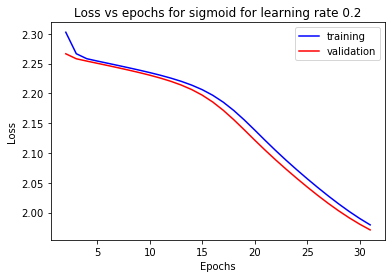

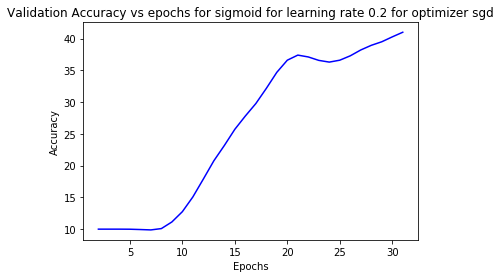

In [3]:
sgd = MLP([784,128,10], 'sigmoid', 0.2, 'random', len(x_train), 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:29<00:00,  2.97s/it]


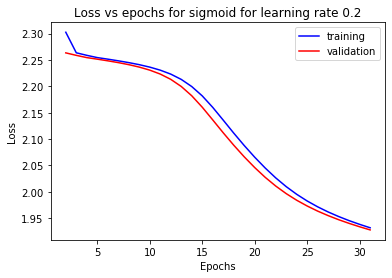

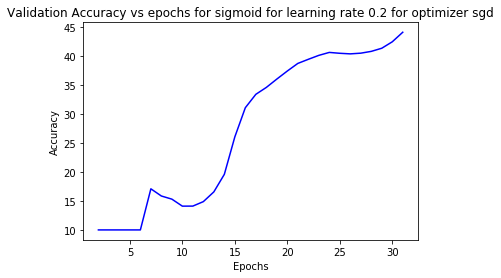

In [4]:
sgd = MLP([784,256,10], 'sigmoid', 0.2, 'random', len(x_train), 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:36<00:00,  5.21s/it]


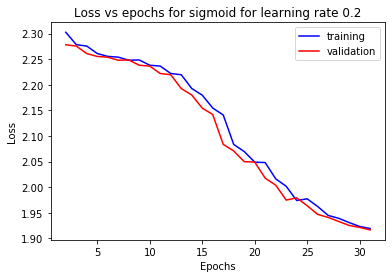

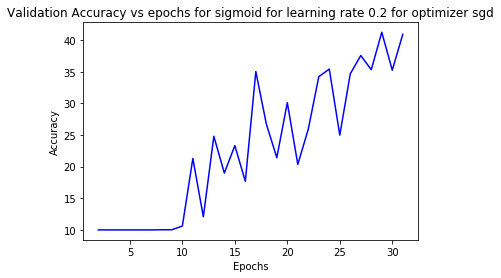

In [5]:
sgd = MLP([784,512,10], 'sigmoid', 0.2, 'random', len(x_train), 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:39<00:00,  3.33s/it]


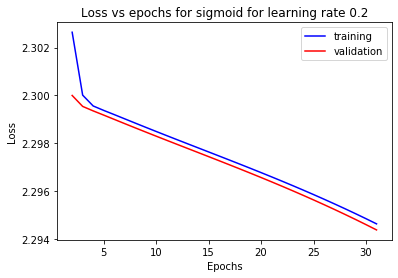

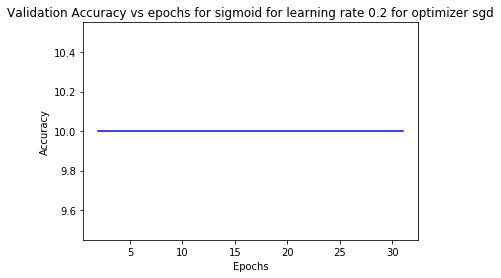

In [3]:
sgd = MLP([784,256,128,10], 'sigmoid', 0.2, 'random', len(x_train), 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:37<00:00,  7.25s/it]


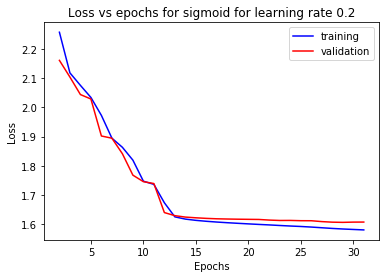

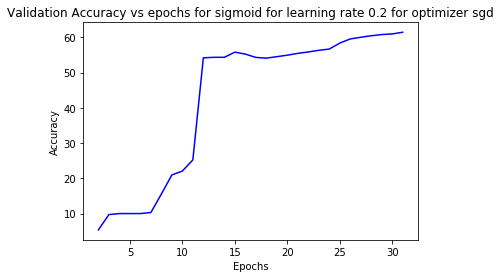

In [4]:
sgd = MLP([784,256,128,10], 'sigmoid', 0.2, 'random', 128, 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:42<00:00,  9.40s/it]


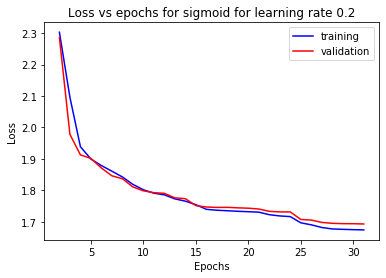

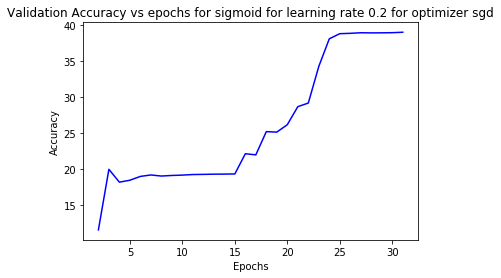

In [5]:
sgd = MLP([784,256,128,64,10], 'sigmoid', 0.2, 'random', 128, 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [03:31<00:00,  7.03s/it]


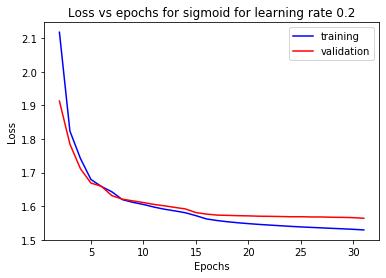

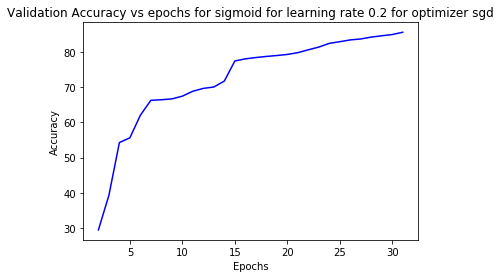

In [7]:
sgd = MLP([784,256,32,10], 'sigmoid', 0.2, 'random', 128, 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [04:01<00:00,  8.04s/it]


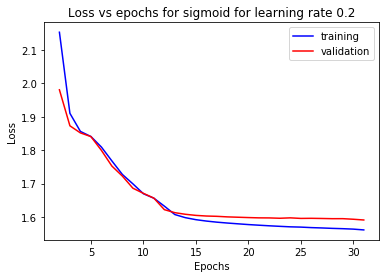

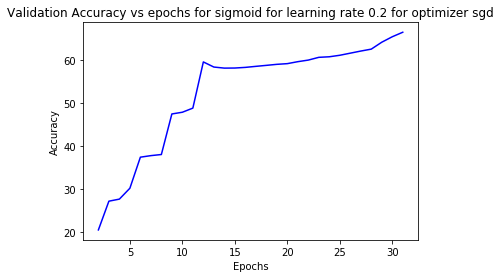

In [8]:
sgd = MLP([784,256,16,10], 'sigmoid', 0.2, 'random', 128, 30, 'sgd')
sgd.fit(x_train,y_train,x_test,y_test)

# Experiments on Activation

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.05s/it]


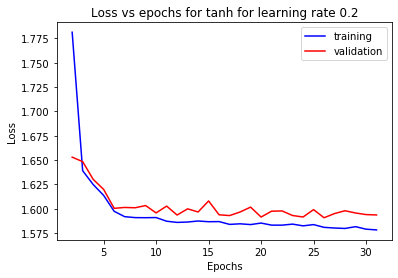

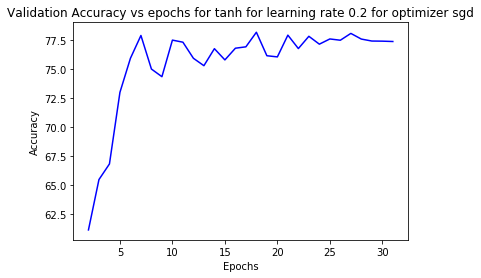

In [11]:
sgd_tanh = MLP([784,256,32,10], 'tanh', 0.2, 'random', 128, 30, 'sgd')
sgd_tanh.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.94s/it]


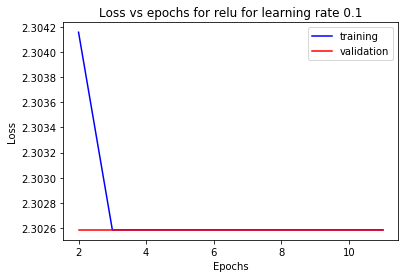

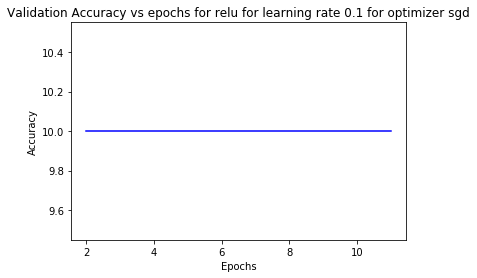

In [35]:
sgd_relu = MLP([784,256,32,10],'relu', 0.1, 'random', 128, 10, 'sgd')
sgd_relu.fit(x_train_scaled,y_train,x_test_scaled,y_test)

In [36]:
sgd_relu.train_loss

[2.304155977311334,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406,
 2.30258509209406]

# Experiments on Optimizer

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.49s/it]


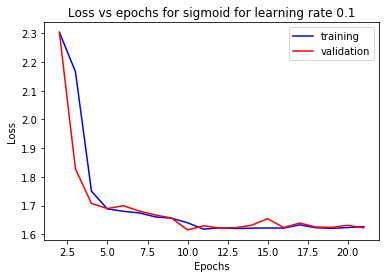

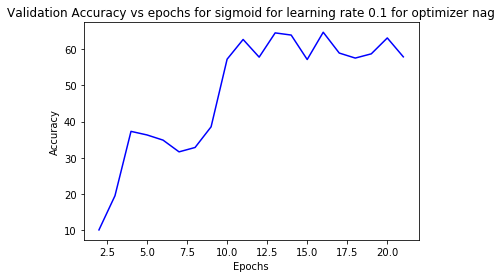

In [4]:
nag = MLP([784,256,32,10], 'sigmoid', 0.1, 'random', 64, 20, 'nag')
nag.fit(x_train_scaled,y_train,x_test_scaled,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:02<00:00,  6.13s/it]


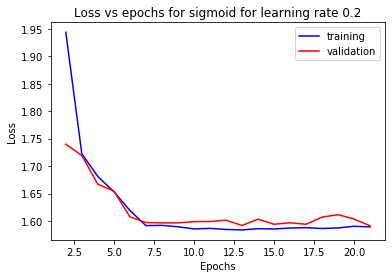

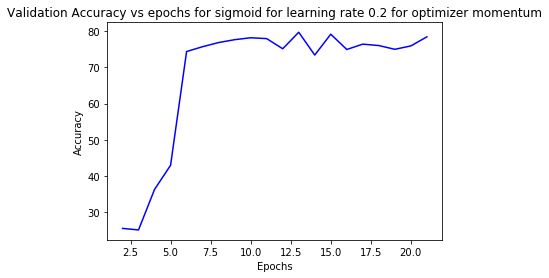

In [4]:
momentum = MLP([784,256,32,10], 'sigmoid', 0.2, 'random', 64, 20, 'momentum')
momentum.fit(x_train_scaled,y_train,x_test_scaled,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.21s/it]


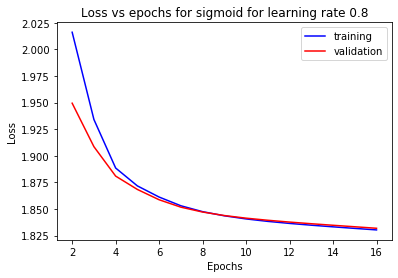

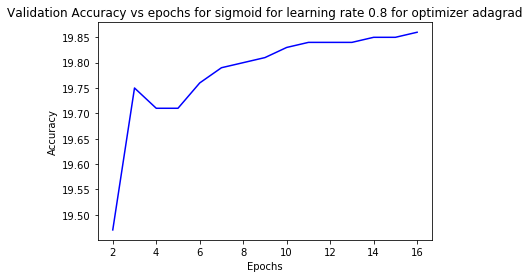

In [11]:
adagrad = MLP([784,256,32,10], 'sigmoid', 0.8, 'random', 64, 15, 'adagrad')
adagrad.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [01:31<00:00,  6.13s/it]


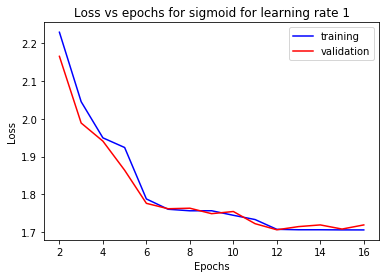

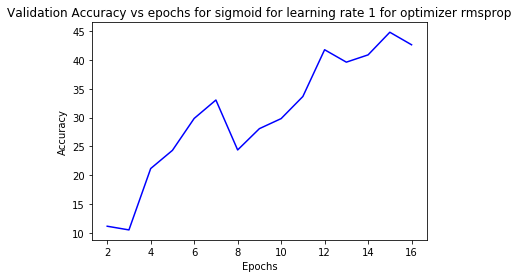

In [14]:
rmsprop = MLP([784,256,32,10], 'sigmoid', 1, 'random', 64, 15, 'rmsprop')
rmsprop.fit(x_train_scaled,y_train,x_test_scaled,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:59<00:00,  5.98s/it]


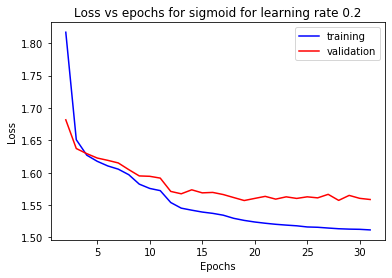

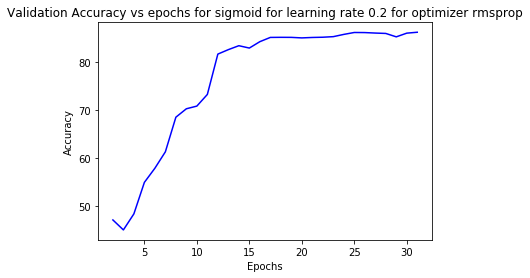

In [16]:
rmsprop = MLP([784,256,32,10], 'sigmoid', 0.2, 'random', 64, 30, 'rmsprop')
rmsprop.fit(x_train,y_train,x_test,y_test)

Epoch : 100%|██████████████████████████████████████████████████████████████████████████| 20/20 [07:29<00:00, 22.47s/it]


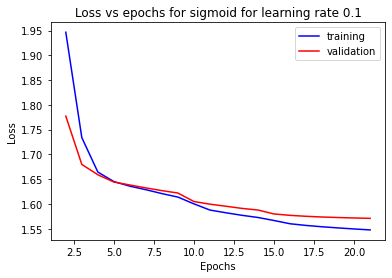

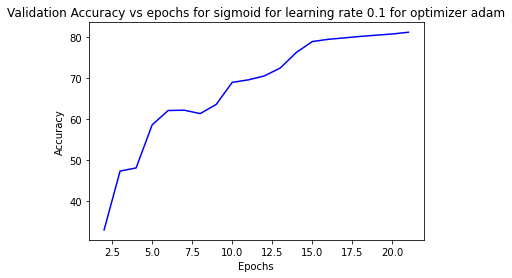

In [4]:
adam = MLP([784,256,32,10], 'sigmoid', 0.1, 'random', 64, 20, 'adam')
adam.fit(x_train,y_train,x_test,y_test)